# Příklad zpracování sktrukturovaných dat v Kerasu
https://keras.io/examples/structured_data/structured_data_classification_from_scratch/

Co se naučíme:
* Co jsou strukturovaná data a jak je lze uložit.
* Jak přemýšlet o závislostech ve strukturovaných datech a jejich modelování.
* Nejzákladnější základ Kerasu:
    * vytvoření datasetu,
    * příprava strukturovaných dat pro trénování,
    * vytvoření a natrénování modelu,
    * inference.

#### Začneme importem potřebných knihoven

In [ ]:
random_seed = 42000 # nastavení náhodného seedu pro reprodukovatelnost výsledků

%matplotlib widget
import ipywidgets
import ipympl
import prettytable as pt # knihovna pro výpis tabulek
import matplotlib.pyplot as plt # knihovna pro vykreslování grafů
# nastavení parametrů pro vykreslování
colorbins = 100 # number of bins for plotting
cmap = 'jet' # color map for plotting

import numpy as np # matematická knihovna pro multidimenzionální výpočty
import pandas as pd # knihovna pro práci s daty

import tensorflow as tf # knihovna pro strojové učení
from tensorflow.keras import layers # vrstvy pro sestavení modelu
import keras # vysokoúrovňové API pro sestavení a trénování modelů hlubokého učení


print("Version of tensorflow: " + tf.__version__)
print("Version of keras: " + keras.__version__)
print("Version of numpy: " + np.__version__)
print("Version of pandas: " + pd.__version__)
print("Version of ipywidgets: " + ipywidgets.__version__)
print("Version of ipympl: " + ipympl.__version__)

Version of tensorflow: 2.13.0
Version of keras: 2.13.1
Version of numpy: 1.24.3
Version of pandas: 2.0.3
Version of ipywidgets: 7.7.2
Version of ipympl: 0.9.1


### Co jsou strukturovaná data?

#### Stáhneme si veřejně dostupný dataset onemocnění srdce::
Spracujeme data pomocí pandas.DataFrame - dokumentace zde: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

In [ ]:
file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
dataframe = pd.read_csv(file_url)

# Jak jsou data uložena?
dataframe.head() # zobrazí prvních 5 řádků

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


#### co to znamená?
Dekódujme si numerické hodnoty a vytiskněme data pro některé pacienty...

In [ ]:
# Tyto hodnoty známe z dokumentace k datasetu https://archive.ics.uci.edu/ml/datasets/heart+Disease
pain_types = ['unknown', 'typical angina', 'atypical angina', 'non-anginal pain', 'asymptomatic']
sexes = ['Female', 'Male']
YesNo = ['No', 'Yes']
electrocardiographic_results = ['normal', 'ST-T wave abnormality', 'left ventricular hypertrophy']
slopes = ['unknown', 'upsloping', 'flat', 'downsloping']

# Metoda pro pěknější vytištění našich dat
def print_data(dataframe, patient_index):

    datarow = dataframe.iloc[patient_index]

    # poskládáme si tabulku
    table = pt.PrettyTable()
    table.field_names = ["Shortcut", "Description", "Value for patient number " + str(patient_index)  ]
    table.add_row(["age", "age in years", datarow[0]])
    table.add_row(["sex", "biological sex", sexes[datarow[1]]])
    table.add_row(["cp", "Chest pain type (0, 1, 2, 3, 4)", pain_types[datarow[2]]])
    table.add_row(["trestbps", "Resting blood pressure (in mm Hg on admission)", datarow[3]])
    table.add_row(["chol", "Cholesterol in mg/dl", datarow[4]])
    table.add_row(["fbs", "Fasting blood sugar in 120 mg/dl", YesNo[datarow[5]]])
    table.add_row(["restecg", "Resting electrocardiographic results", electrocardiographic_results[datarow[6]]])
    table.add_row(["thalach", "Maximum heart rate achieved", datarow[7]])
    table.add_row(["exang", "Exercise induced angina", YesNo[datarow[8]]])
    table.add_row(["oldpeak", "ST depression induced by exercise relative to rest", datarow[9]])
    table.add_row(["slope", "Peak exercise ST segment", slopes[datarow[10]]])
    table.add_row(["ca", "Number of major vessels (0-3) colored by fluoroscopy", datarow[11]])
    table.add_row(["thal", "Thal (3 = normal; 6 = fixed defect; 7 = reversible defect)", datarow[12]])
    table.add_row(["target", "Diagnosis of heart disease", datarow[13]])


    # vytištění tabulky
    print(table)

# vytištění příkladu dat - změníme parametr patient_index pro zobrazení jiného pacienta
for i in range(5):
    print_data(dataframe,patient_index=i)

+----------+------------------------------------------------------------+------------------------------+
| Shortcut |                        Description                         |  Value for patient number 0  |
+----------+------------------------------------------------------------+------------------------------+
|   age    |                        age in years                        |              63              |
|   sex    |                       biological sex                       |             Male             |
|    cp    |              Chest pain type (0, 1, 2, 3, 4)               |        typical angina        |
| trestbps |       Resting blood pressure (in mm Hg on admission)       |             145              |
|   chol   |                    Cholesterol in mg/dl                    |             233              |
|   fbs    |              Fasting blood sugar in 120 mg/dl              |             Yes              |
| restecg  |            Resting electrocardiographic re

### Intuice za modely

#### Proč tomu říkáme "model"? Co je to "model" obecně? Jaké jsou nějaké příklady modelů?
Inspirace: https://en.wikipedia.org/wiki/Model_(disambiguation)

Podívejme se na jednu z proměnných - věk. Můžeme předpovědět srdeční chorobu jen z věku?



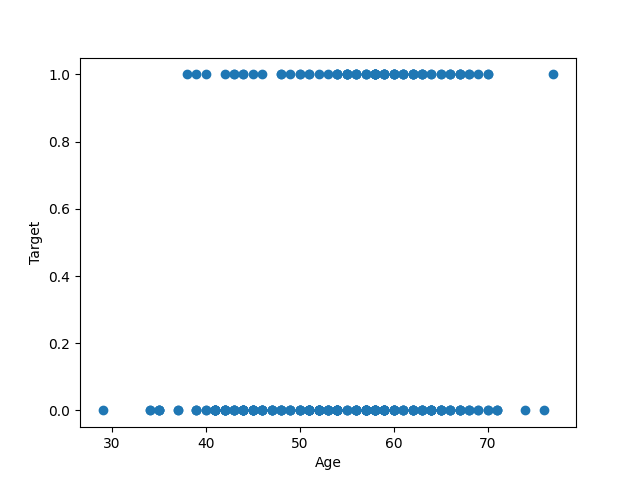

In [ ]:
# vyzobneme z datasetu pouze proměnné věk, typ bolesti a pravděpodobnost výskytu srdečního onemocnění (target)
tmp = dataframe.copy()
labels_orig = tmp.pop("target")
ages_orig = tmp.pop("age")
cp_orig = tmp.pop("cp")

# Vykreslíme si graf závislosti onemocnění na věku, kde na ose x bude věk a na ose y pravděpodobnost výskytu srdečního onemocnění
fig = plt.figure()
plt.scatter(ages_orig, labels_orig)
plt.xlabel("Age")
plt.ylabel("Target")
plt.show()


#### To nám moc nepomohlo... co když přidáme proměnnou typu bolesti?

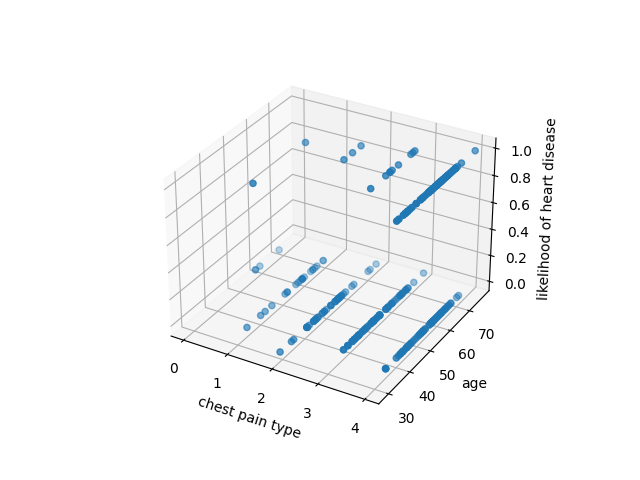

In [ ]:
# Pridáme další proměnnou a zobrazíme si 3d graf
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(cp_orig, ages_orig, labels_orig)

# osy x a y jsou proměnné, které máme k dispozici
ax.set_xlabel('chest pain type')
ax.set_ylabel('age')

# osa z je proměnná, kterou chceme predikovat
ax.set_zlabel('likelihood of heart disease')

plt.show()


### Zkusme odhadnout model pravdepodobnosti vzniku srdecni choroby jen z dostupnych dat

Zinterpolujeme data pro odhad chybějících hodnot - vysvětlení interpolace zde: https://en.wikipedia.org/wiki/Multivariate_interpolation

Using 242 samples for training and 61 for validation from the dataset of 303 samples in total


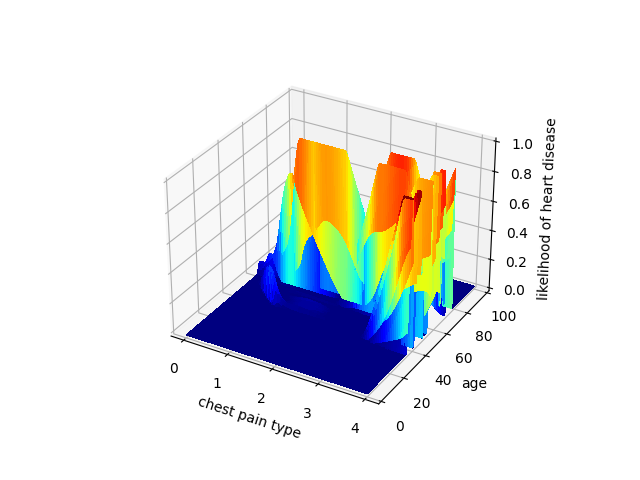

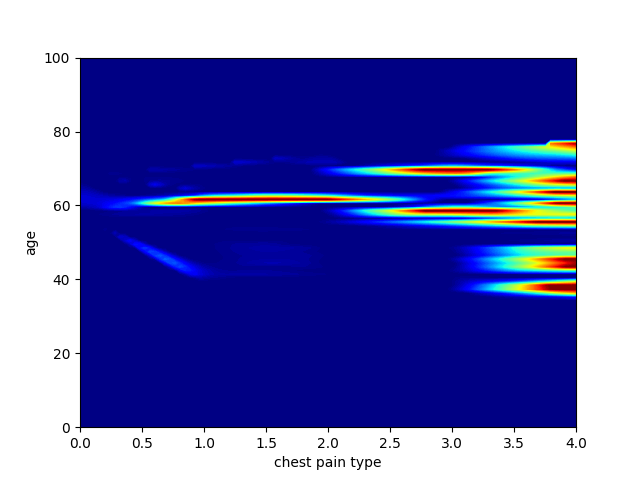

In [ ]:
# Vezmeme si z datasetu jenom sloupce, které nás zajímají
smol = dataframe.copy()
smol = smol[["cp", "age", "target"]]

# náhodně si rozdělíme data na trénovací a validační množinu v poměru 80:20
val_smol = smol.sample(frac=0.2, random_state=random_seed)
train_smol = smol.drop(val_smol.index)

# local copy of the data
val_smol_copy = val_smol.copy()
train_smol_copy = train_smol.copy()

print(
    "Using %d samples for training and %d for validation from the dataset of %d samples in total"
    % (len(train_smol), len(val_smol), len(dataframe))
)

# get the labels from the training and validation data
train_labels_smol = train_smol_copy.pop("target")
val_labels_smol = val_smol_copy.pop("target")

train_age_smol = train_smol_copy.pop("age")
val_age_smol = val_smol_copy.pop("age")

train_cp_smol = train_smol_copy.pop("cp")
val_cp_smol = val_smol_copy.pop("cp")


# interpolujeme data pomocí scipy ------------------------------------------------------------------------------
from scipy.interpolate import griddata
import numpy as np

# vytvoříme si sadu vstupních hodnot, pro které chceme získat interpolované hodnoty
grid_x_naive, grid_y_naive = np.mgrid[0:4:100j, 0:100:100j]

# interpolujeme data
grid_z_naive = griddata((train_cp_smol, train_age_smol), train_labels_smol, (grid_x_naive, grid_y_naive), method='cubic', fill_value=0)

# ořízneme hodnoty, které jsou mimo rozsah 0-1 (slušná pravděpodobnost by měla být v tomto rozsahu)
grid_z_naive = np.clip(grid_z_naive, 0, 1)

# zobrazíme si interpolovaná data ---------------------------------------------------------------------------
fig = plt.figure()
ax_naive = fig.add_subplot(projection='3d')

ax_naive.plot_surface(grid_x_naive, grid_y_naive, grid_z_naive,cmap=cmap,rstride=1, cstride=1,
                       linewidth=0, antialiased=False, shade=False)

ax_naive.set_xlabel('chest pain type')
ax_naive.set_ylabel('age')
ax_naive.set_zlabel('likelihood of heart disease')

ax_naive.set_zlim(0, 1)
ax_naive.set_ylim(0, 100)

plt.show()

fig = plt.figure()

ax2d_naive = fig.add_subplot()
ax2d_naive.contourf(grid_x_naive, grid_y_naive, grid_z_naive, colorbins,cmap=cmap)
ax2d_naive.set_xlabel('chest pain type')
ax2d_naive.set_ylabel('age')

ax2d_naive.set_ylim(0, 100)

plt.show()



#### Je pravděpodobné, že v 50 letech pravděpodobnost náhle klesne a pak se znovu zvýší?

Co když data vyhladíme? To můžeme třeba Gaussovým filtrem: https://en.wikipedia.org/wiki/Gaussian_filter

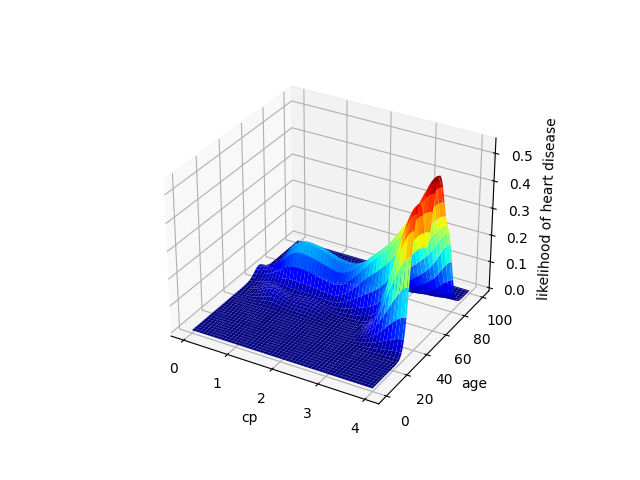

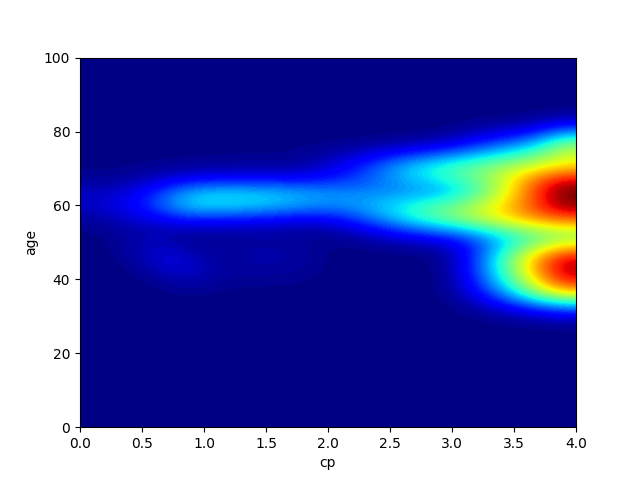

In [ ]:
from scipy.ndimage import gaussian_filter

# přefiltrujeme data
grid_z_naive_smooth = gaussian_filter(grid_z_naive, sigma=4)

# ořízneme data, aby se vešla do rozsahu 0 až 1
grid_z_naive_smooth = np.clip(grid_z_naive_smooth, 0, 1)

# vykreslíme jako 3D graf
fig = plt.figure()
ax_naive_smooth = fig.add_subplot(projection='3d')

ax_naive_smooth.plot_surface(grid_x_naive, grid_y_naive, grid_z_naive_smooth, cmap=cmap)

ax_naive_smooth.set_xlabel('cp')
ax_naive_smooth.set_ylabel('age')
ax_naive_smooth.set_zlabel('likelihood of heart disease')

plt.show()

fig = plt.figure()

ax2d_naive_smooth = fig.add_subplot()
ax2d_naive_smooth.contourf(grid_x_naive, grid_y_naive, grid_z_naive_smooth,colorbins, cmap=cmap)
ax2d_naive_smooth.set_xlabel('cp')
ax2d_naive_smooth.set_ylabel('age')

ax2d_naive_smooth.set_ylim(0, 100)

plt.show()

#### Teď máme model, který nám říká, že starší lidé s bolestí na hrudi mají největší pravděpodobnost mít srdeční chorobu 👍👍👍.

(Mimochodem pravděpodobnost se zázračně snižuje po 70 letech... )

Jaká je přesnost našeho modelu? Metrika přesnosti: https://keras.io/api/metrics/accuracy_metrics/

In [ ]:

def evaluate_predictions(labels, predictions):
    '''
    Funkce pro vyhodnocení predikcí. Vrací accuracy a práh, při kterém byla dosažena nejvyšší accuracy.
    (Práh znamená, že pokud je predikce vyšší než práh, tak se predikuje třída 1, jinak 0.)
    '''
    best_threshold = 0
    best_accuracy = 0
    for threshold in np.arange(0, 1, 0.01):
        metric = tf.keras.metrics.Accuracy()
        metric.update_state(labels, np.array(predictions) > threshold)
        accuracy = metric.result().numpy()
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

    return best_accuracy, best_threshold

# Spočítáme predikce na validačních datech
predictions = []
for i in range(len(val_cp_smol.values)):

    # najdeme nejbližší index v mřížce pro daný sample (náš model předpovídá jen na mřížce)
    x_index = np.argmin(np.abs(grid_x_naive[:, 0] - val_cp_smol.values[i]))

    # to stejné pro proměnnou y
    y_index = np.argmin(np.abs(grid_y_naive[0, :] - val_age_smol.values[i]))

    # jaká je hodnota modelu na daných indexech?
    predictions.append(grid_z_naive_smooth[x_index, y_index])


metric = tf.keras.metrics.Accuracy()
metric.update_state(val_labels_smol, np.array(predictions) > 0.5)

print("Naive model accuracy with threshold 0.5: {:.2f}%".format(metric.result().numpy() * 100))

best_accuracy, best_threshold = evaluate_predictions(val_labels_smol, predictions)

print("Naive model best accuracy: {:.2f}% at threshold {:.2f}".format(best_accuracy * 100, best_threshold))


Naive model accuracy with threshold 0.5: 70.49%
Naive model best accuracy: 77.05% at threshold 0.52


#### Zní to dost dobře? Co jsme to vlastně vytvořili za model? Podívejme se, jak vypadá funkce vyprahovaná nejlepší hodnotou prahu...

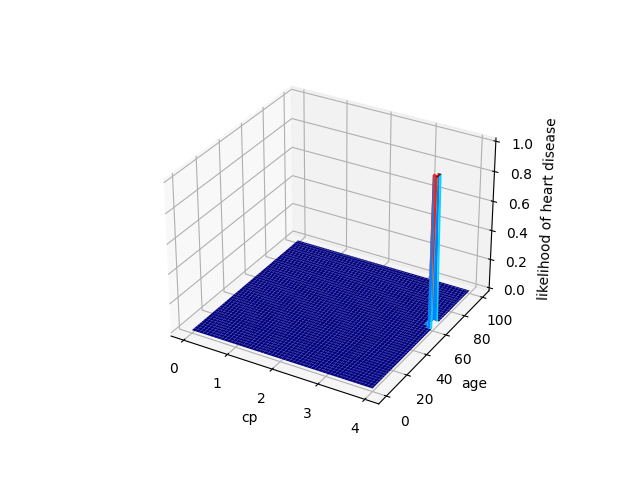

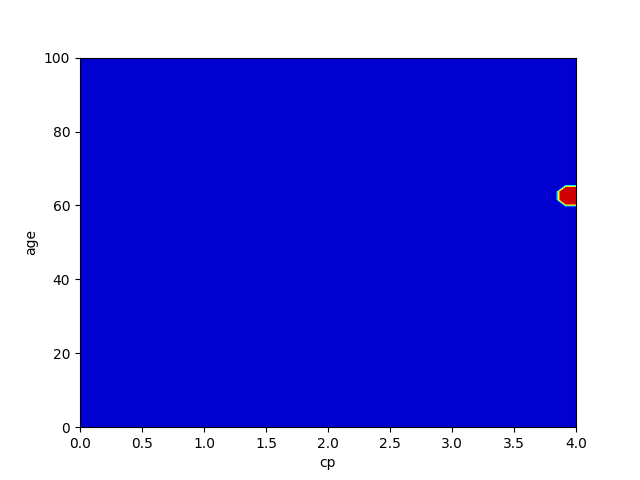

In [ ]:
fig = plt.figure()
ax_naive_smooth = fig.add_subplot(projection='3d')

# vyprahujeme interpolovaná a vyhlazená data
grid_z_naive_smooth_thresholded = grid_z_naive_smooth > best_threshold

ax_naive_smooth.plot_surface(grid_x_naive, grid_y_naive, grid_z_naive_smooth_thresholded, cmap=cmap)

ax_naive_smooth.set_xlabel('cp')
ax_naive_smooth.set_ylabel('age')
ax_naive_smooth.set_zlabel('likelihood of heart disease')

plt.show()

fig = plt.figure()

ax2d_naive_smooth = fig.add_subplot()
ax2d_naive_smooth.contourf(grid_x_naive, grid_y_naive, grid_z_naive_smooth_thresholded, cmap=cmap)
ax2d_naive_smooth.set_xlabel('cp')
ax2d_naive_smooth.set_ylabel('age')

ax2d_naive_smooth.set_ylim(0, 100)

plt.show()

### Vyzkoušíme natrénovat neuronovou síť na naší datové podmnožině

#### Vytvoření datasetu pro trénování
Použijeme třídu tf.data.Dataset - https://www.tensorflow.org/api_docs/python/tf/data/Dataset

Naše data jsou teď datového typu Tensor - https://www.tensorflow.org/api_docs/python/tf/Tensor

In [ ]:
def dataframe_to_dataset(dataframe):
    '''
    Funkce pro převod pandas dataframe do tensorflow datasetu.
    '''

    # lokálkní kopie dat
    dataframe = dataframe.copy()

    # vyjmeme cílový sloupec z dat, to je sloupec, který chceme predikovat - prognóza srdeční choroby
    labels = dataframe.pop("target")

    # vytvoříme dvojice (vstupní data, cílová hodnota)
    new_data_format = (dict(dataframe), labels)

    # vytvoříme tensorflow dataset
    ds = tf.data.Dataset.from_tensor_slices(new_data_format)

    # přehážeme data
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


# vytvoříme dva datasety, jeden pro trénování a druhý pro validaci
train_ds = dataframe_to_dataset(train_smol)
val_ds = dataframe_to_dataset(val_smol)


# zobrazíme si pár prvků z trénovacího datasetu
for x, y in train_ds.take(5):
    print("Input (tensor with our structured data):", x)
    print("Target (tensor with value 0 or 1):", y)



Input (tensor with our structured data): {'cp': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'age': <tf.Tensor: shape=(), dtype=int64, numpy=57>}
Target (tensor with value 0 or 1): tf.Tensor(0, shape=(), dtype=int64)
Input (tensor with our structured data): {'cp': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'age': <tf.Tensor: shape=(), dtype=int64, numpy=57>}
Target (tensor with value 0 or 1): tf.Tensor(1, shape=(), dtype=int64)
Input (tensor with our structured data): {'cp': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'age': <tf.Tensor: shape=(), dtype=int64, numpy=66>}
Target (tensor with value 0 or 1): tf.Tensor(0, shape=(), dtype=int64)
Input (tensor with our structured data): {'cp': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'age': <tf.Tensor: shape=(), dtype=int64, numpy=50>}
Target (tensor with value 0 or 1): tf.Tensor(0, shape=(), dtype=int64)
Input (tensor with our structured data): {'cp': <tf.Tensor: shape=(), dtype=int64, numpy=4>, 'age': <tf.Tensor: shape=(), dtype=int6

#### Vytvoříme dávky (batches) dat pro trénování

We well use batches if data to train and evaluate the model. Notice, what happens now when we call "take" on the dataset.
Model se trénuje po malých podmnožinách dat, které se nazývají dávky (batches). Dávku si z datasetu můžeme vybrat pomocí metody "take". Všimněte si, co se stane, když zavoláme "take" na datasetu.

In [ ]:
# kolik vzorků je v batchi
batch_size = 32

# "nabatchujeme" datsety
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

# pozor - toto se rozbije, pokud se spustí vícekrát - spusťte předchozí buňku pro reset datasetu
print("The first batch of the training dataset:")
for input, label in train_ds.take(1):
    print(input)
    print(label)

The first batch of the training dataset:
{'cp': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([3, 4, 4, 4, 4, 4, 1, 4, 3, 4, 4, 3, 4, 0, 1, 4, 2, 4, 3, 2, 3, 2,
       4, 4, 4, 3, 3, 4, 4, 4, 1, 2], dtype=int64)>, 'age': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([49, 63, 77, 65, 71, 63, 65, 43, 51, 53, 67, 68, 42, 59, 59, 43, 57,
       62, 54, 44, 58, 41, 61, 56, 58, 58, 39, 64, 55, 61, 60, 56],
      dtype=int64)>}
tf.Tensor([1 0 1 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 0], shape=(32,), dtype=int64)


### Zakódujeme data tak, aby byly ve vhodnějším formátu pro model

Použijeme tyto Kerasové vrstvy:
* tensorflow.keras.layers.Normalization: https://keras.io/api/layers/preprocessing_layers/numerical/normalization/
* tensorflow.keras.layers.IntegerLookup: https://keras.io/api/layers/preprocessing_layers/categorical/integer_lookup/

Takto bude předzpracování součástí našeho modelu, takže se nemusíme starat o to, aby bylo provedeno "ručně" před inferencí...

In [ ]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization

def encode_numerical_feature(feature, name, dataset):
    '''
    Zakódování spojitých dat (v tomto případě pouze věk).
    Normalizace znamená, že se data převedou do rozmezí 0 až 1 podle průměru a rozptylu hodnot.
    '''

    # Normalizace dat
    normalizer = Normalization()

    # Připravíme dataset, který bude obsahovat pouze zvolenou vlastnost (určuje se podle "name")
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Zjištění průměru a rozptylu pro normalizaci
    normalizer.adapt(feature_ds)

    print("This is our mean for " + str(name) + " features: " + str(normalizer.mean.numpy()))
    print("This is our variance for " + str(name) + " features: " + str(normalizer.variance.numpy()))

    # Normalizace dat
    encoded_feature = normalizer(feature)
    return encoded_feature

# We will use this for integer categorical features (now only cp is categorical)
def encode_categorical_feature(feature, name, dataset):
    '''
    Zakódování kategorických dat (v tomto případě pouze cp).
    Data u kterých očekáváme, že budou mít hodnoty z omezeného počtu kategorií zakódujeme pomocí vyhledávací tabulky.
    '''

    # Kategorie reprezentujeme pomocí celých čísel
    lookup_class = IntegerLookup

    lookup = lookup_class(output_mode='one_hot')

    # Připravíme dataset, který bude obsahovat pouze zvolenou vlastnost (určuje se podle "name")
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Zjistíme všechny možné hodnoty pro danou vlastnost a připravíme si vyhledávací tabulku
    lookup.adapt(feature_ds)

    print("This is our lookup for " + str(name) + " features: " + str(lookup.get_vocabulary()))

    # Zjistíme jak vypadá zakódovaná vlastnost pro všechny možné hodnoty
    example_of_all_possible_values = tf.constant([0, 1, 2, 3, 4])
    print("This is what our encoded feature looks like for all possible values: " + str(lookup(example_of_all_possible_values)))

    # Zakódování vlastnosti
    encoded_feature = lookup(feature)


    return encoded_feature


#### Postavíme model

Použijeme tyto Kerasové vrstvy:
* keras.layers.Dense: https://keras.io/api/layers/core_layers/dense/
* keras.layers.Dropout: https://keras.io/api/layers/regularization_layers/dropout/
* keras.Model: https://keras.io/api/models/model/
* aktivační funkce ReLu a Simoid: https://keras.io/api/layers/activations/

Teď můžeme vytvořit model a vizualizovat ho:

This is our lookup for cp features: [-1, 4, 3, 2, 1, 0]
This is what our encoded feature looks like for all possible values: tf.Tensor(
[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]], shape=(5, 6), dtype=float32)
This is our mean for age features: [[55.11984]]
This is our variance for age features: [[79.54349]]


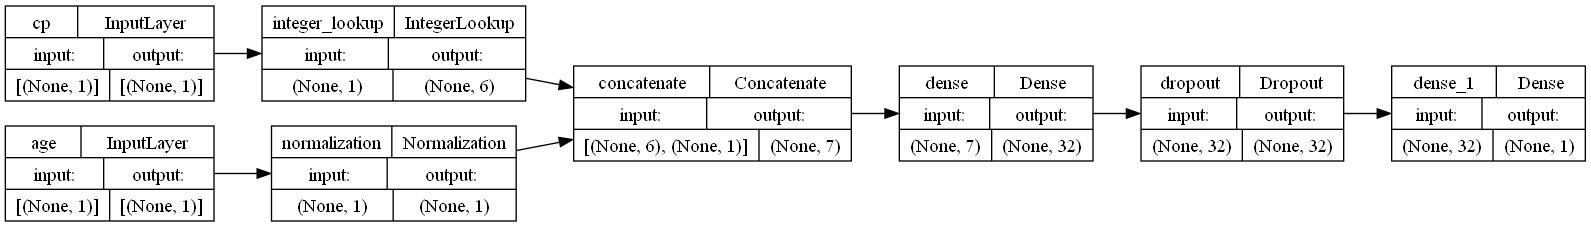

In [ ]:
# Vstupní vrstva pro typ bolesti na hrudi
cp = keras.Input(shape=(1,), name="cp", dtype="int64")

# Vstupní vrstva pro věk
age = keras.Input(shape=(1,), name="age")

all_inputs = [
    cp,
    age
]

# Zakódování typu bolesti
cp_encoded = encode_categorical_feature(cp, "cp", train_ds)

# Zakódování věku
age_encoded = encode_numerical_feature(age, "age", train_ds)

# Spojení zakódovaných vstupů
all_features = layers.concatenate(
    [
        cp_encoded,
        age_encoded
    ]
)

# Plně propojená vrstva s 32 neurony a aktivační funkcí ReLU
x = layers.Dense(units=32, activation="relu")(all_features)

# Dropout vrstva s 0.5 pravděpodobností
x = layers.Dropout(rate=0.5)(x)

# Výstupní vrstva s jedním neuronem a aktivační funkcí sigmoid
output = layers.Dense(units=1, activation="sigmoid")(x)

# Vytvoření modelu
model = keras.Model(all_inputs, output)

# Kompilace modelu (použití trénovacího algoritmu Adam a jako loss funkci použijeme binary_crossentropy)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

# in case of error: pydot.InvocationException: GraphViz's executables not found, we need to add the path to the graphviz executables to the PATH environment variable
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# Zobrazíme si graf našeho modelu
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


* V předchozím obrázku vidíme, že náš model "požírá" data cp a age pomocí vstupních vrstev.
* Na vstupní vrstvy navazuje zakódování.
* Zakódovaná data vstupují do plně propojené vrstvy.
* Dropout vrstva nám pomáhá zabránit přeučení - při trénování náhodně vypíná některé neurony.
* Následuje výstupní vrstva, která nám vrací výsledek.

#### Samotné trénování je v Kerasu velmi jednoduché :)

In [ ]:
# počet epoch - kolikrát se projde celý dataset
epochs = 60

# trénování modelu
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


Epoch 1/60


8/8 [==============================] - 1s 21ms/step - loss: 0.7838 - accuracy: 0.4215 - val_loss: 0.6901 - val_accuracy: 0.5902
Epoch 2/60
8/8 [==============================] - 0s 4ms/step - loss: 0.7572 - accuracy: 0.4215 - val_loss: 0.6665 - val_accuracy: 0.5902
Epoch 3/60
8/8 [==============================] - 0s 4ms/step - loss: 0.7026 - accuracy: 0.5207 - val_loss: 0.6454 - val_accuracy: 0.6557
Epoch 4/60
8/8 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5496 - val_loss: 0.6266 - val_accuracy: 0.6230
Epoch 5/60
8/8 [==============================] - 0s 4ms/step - loss: 0.6690 - accuracy: 0.5868 - val_loss: 0.6096 - val_accuracy: 0.6721
Epoch 6/60
8/8 [==============================] - 0s 4ms/step - loss: 0.6439 - accuracy: 0.6281 - val_loss: 0.5960 - val_accuracy: 0.7213
Epoch 7/60
8/8 [==============================] - 0s 4ms/step - loss: 0.6518 - accuracy: 0.6116 - val_loss: 0.5842 - val_accuracy: 0.7377
Epoch 8/60
8/8 [============================

### Teď můžeme použít model na reálná data

In [ ]:

# Tady si připravíme data, pro které chceme znát predikci.
# Zkuste změnit hodnoty a sledovat, jak se mění predikce. (Chest pain musí být některá z kategorií, které náš model zná.)
sample = {
    "age": 16,

    # Chest pain type
    "cp": pain_types.index("asymptomatic"), # one of 'unknown', 'typical angina', 'atypical angina', 'non-anginal pain', 'asymptomatic'
}

# Vložíme data do modelu a získáme predikci
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

# Zobrazíme si, co model predikoval
print(
    "This particular patient had a %.1f percent probability "
    "of having a heart disease, as evaluated by our model." % (100 * predictions[0][0],)
)


1/1 [==============================] - 0s 90ms/step
This particular patient had a 7.4 percent probability of having a heart disease, as evaluated by our model.


### Jak vypadá tento natrénovaný model?

Zkusíme do modelu nacpat spoustu dat a z výsledků si vykreslíme graf.

In [ ]:

# Nachystáme si rozsah možných hodnot pro věk a cp
grid_age = np.arange(0, 100, 1)
grid_cp = np.arange(0, 5, 1)

# pustíme předikce pro všechny kombinace věků a cp a sledujeme průběh predikce pomocí tqdm
possible_ages = []
possible_cps = []
predictions = []

# tqdm je knihovna, která nám umožní sledovat průběh výpočtu (zobrazuje progress bar)
from tqdm import tqdm
for selected_age in tqdm(grid_age):
    for selected_cp in grid_cp:
        input_dict = {
            "age": tf.convert_to_tensor([selected_age]),
            "cp": tf.convert_to_tensor([selected_cp]),
        }
        prediction = model.predict(input_dict,verbose = 0)[0][0]

        # uložíme si výsledky pro pozdější vykreslení
        possible_ages.append(selected_age)
        possible_cps.append(selected_cp)
        predictions.append(prediction)




  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:21<00:00,  4.55it/s]


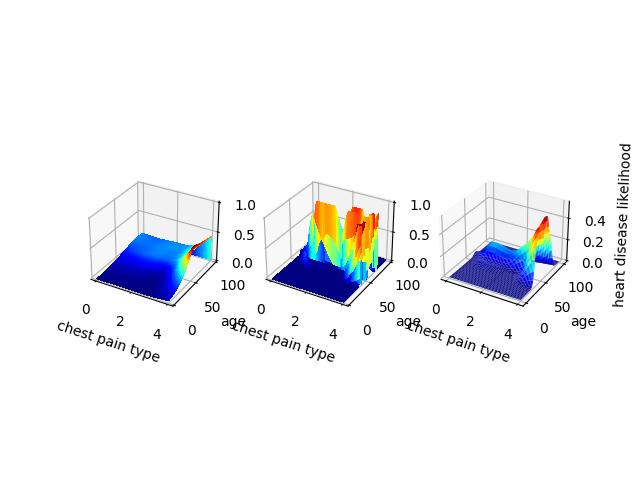

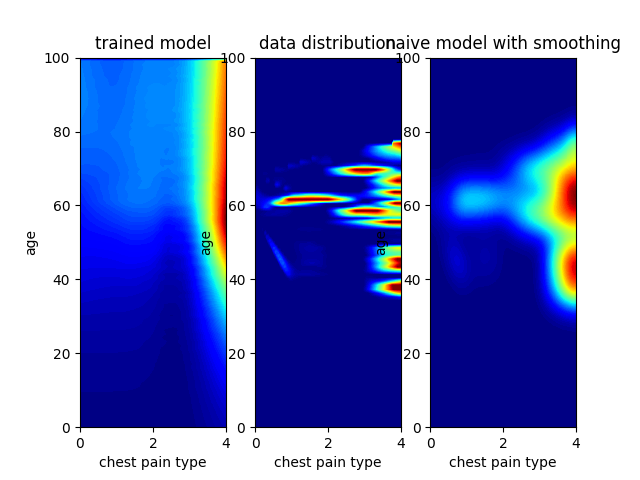

In [ ]:
# Následující kód je pouze pro vykreslení 3D grafů všech našich modelů, nemusíte jej moc zkoumat...


from scipy.interpolate import griddata
import numpy as np

# připravíme si mřížku bodů pro vykreslení
grid_x, grid_y = np.mgrid[0:4:100j, 0:100:100j]

# interpolujeme data
grid_z = griddata((possible_cps, possible_ages), predictions, (grid_x, grid_y), method='cubic', fill_value=0)

# ořízneme hodnoty mimo rozsah
grid_z = np.clip(grid_z, 0, 1)

fig = plt.figure()
ax = fig.add_subplot(131,projection='3d')

ax.plot_surface(grid_x, grid_y, grid_z,cmap=cmap,rstride=1, cstride=1,
                       linewidth=0, antialiased=False, shade=False)

ax.set_xlabel('chest pain type')
ax.set_ylabel('age')

ax.set_zlim(0, 1)
ax.set_ylim(0, 100)

# add the previous 3d plot as a subplot in the figure
ax_naive = fig.add_subplot(132,projection='3d')


ax_naive.plot_surface(grid_x_naive, grid_y_naive, grid_z_naive,cmap=cmap,rstride=1, cstride=1,
                       linewidth=0, antialiased=False, shade=False)

ax_naive.set_xlabel('chest pain type')
ax_naive.set_ylabel('age')

ax_naive.set_zlim(0, 1)
ax_naive.set_ylim(0, 100)

ax_naive_smooth = fig.add_subplot(133,projection='3d')

ax_naive_smooth.plot_surface(grid_x_naive, grid_y_naive, grid_z_naive_smooth, cmap=cmap)

ax_naive_smooth.set_xlabel('chest pain type')
ax_naive_smooth.set_ylabel('age')
ax_naive_smooth.set_zlabel('heart disease likelihood')


plt.show()

fig = plt.figure()

ax2d = fig.add_subplot(131)
ax2d.contourf(grid_x, grid_y, grid_z,colorbins, cmap=cmap)
ax2d.set_xlabel('chest pain type')
ax2d.set_ylabel('age')
ax2d.set_title('trained model')

ax2d.set_ylim(0, 100)

ax2d_naive = fig.add_subplot(132)
ax2d_naive.contourf(grid_x_naive, grid_y_naive, grid_z_naive, colorbins, cmap=cmap)
ax2d_naive.set_xlabel('chest pain type')
ax2d_naive.set_ylabel('age')
ax2d_naive.set_title('data distribution')

ax2d_naive.set_ylim(0, 100)

ax2d_naive_smooth = fig.add_subplot(133)
ax2d_naive_smooth.contourf(grid_x_naive, grid_y_naive, grid_z_naive_smooth, colorbins, cmap=cmap)
ax2d_naive_smooth.set_xlabel('chest pain type')
ax2d_naive_smooth.set_ylabel('age')
ax2d_naive_smooth.set_title('naive model with smoothing')

ax2d_naive_smooth.set_ylim(0, 100)


plt.show()

#### Jak dobrý je náš ML model?

Jak může trénování dopadnout:
* Přetrénování (Overfitting): Model funguje dobře na trénovacích datech, ale špatně na testovacích/validačních datech.
* Nedotrénování (Underfitting): Model funguje špatně na trénovacích datech i na testovacích/validačních datech.
* Dobře natrénovaný model (Good fit): Model funguje dobře na trénovacích datech i na testovacích/validačních datech.
* Podezřele natrénovaný model: Model funguje dobře na testovacích/validačních datech, ale špatně na trénovacích datech.

Typické problémy:
* Špatná vlidační data: Validační data nejsou reprezentativní pro testovací data nebo je validačních dat málo. Např. alidační sada, které zastupuje jenom úzkou část skutečných dat, může zkreslovat vyhodnocení modelu - lepší výsledky na validačních datech než na trenovacích datech.
* Nedostatečná vstupní data: vstupní data neobsahují dostatek informací pro rozumné natrénování modelu. (Nezachycují všechny relevantní vlastnosti.)
* Špatně vybalancovaná data: Některé třídy jsou v datech zastoupeny více než jiné. (Např. 90% pozitivních příkladů a 10% negativních.)
* Malá trénovací sata/Model je příliš velký: Trénovací data nejsou špatně zvolená, ale je jich málo na natrénování takto velkého modelu. (Overfitting)
* Model je příliš malý: Model nemá dostatečnou kapacitu na natrénování. (Underfitting)
* špatná optimalizace: Model se netrénoval dostatečně dlouho nebo se použila špatná optimalizační metoda nebo parametry optimalizace. (Underfitting)


Podívejme se teď na historii trénování našeho modelu. Dokážete odhadnout, jak náš model dopadl?


The model was trained with the following settings:
batch size: 32
epochs: 60
age: mean 54.6, std 9.0 (range 29-77)
traning data age: mean 55.1, std 8.9 (range 34-77)
validation data age: mean 52.5, std 9.0 (range 29-69)



chest pain categories distribution: [0 1 2 3 4], count: [  4  24  49  84 142], percentage: [0.01320132 0.07920792 0.16171617 0.27722772 0.46864686]
traning data chest pain categories distribution: [0 1 2 3 4], count: [  4  19  39  66 114], percentage: [0.01652893 0.0785124  0.16115702 0.27272727 0.47107438]
validation data chest pain categories distribution: [1 2 3 4], count: [ 5 10 18 28], percentage: [0.08196721 0.16393443 0.29508197 0.45901639]



heart disease distribution: [0 1], count: [220  83], percentage: [0.72607261 0.27392739]
traning data heart disease distribution: [0 1], count: [176  66], percentage: [0.72727273 0.27272727]
validation data heart disease distribution: [0 1], count: [44 17], percentage: [0.72131148 0.27868852]



traning data size: 242
va

(0.5, 1.0)

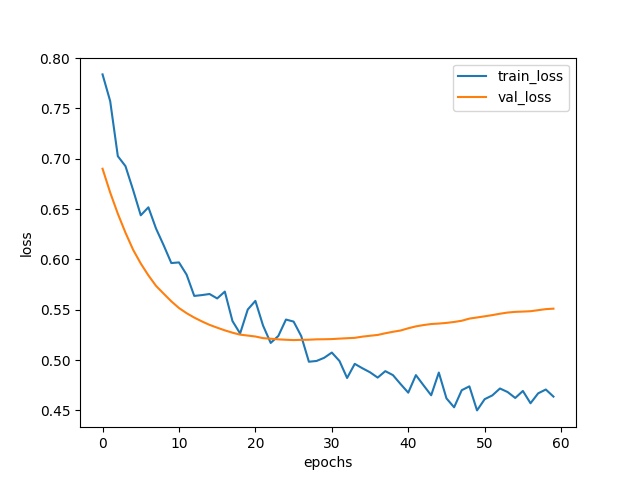

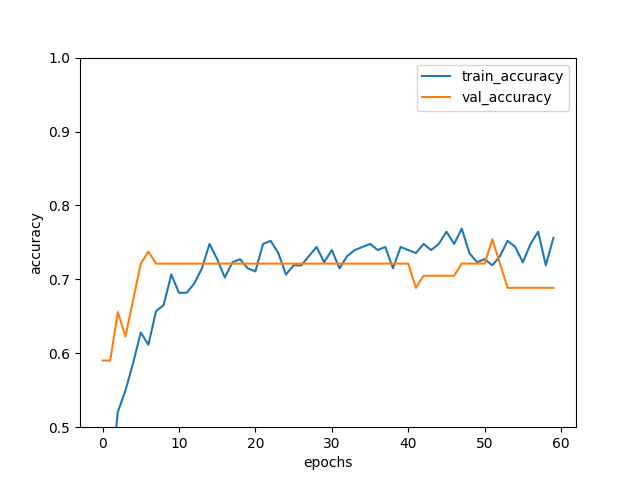

In [ ]:
# Připomeneme si nastavení trénování
print("The model was trained with the following settings:")
print("batch size: %d" % batch_size)
print("epochs: %d" % epochs)


# Vypíšeme si průměrné hodnoty a rozptyly věku v původním datasetu, trénovacích datech a validačních datech
print("age: mean %.1f, std %.1f (range %d-%d)" % (np.mean(ages_orig), np.std(ages_orig), np.min(ages_orig), np.max(ages_orig)))
print("traning data age: mean %.1f, std %.1f (range %d-%d)" % (np.mean(train_age_smol), np.std(train_age_smol), np.min(train_age_smol), np.max(train_age_smol)))
print("validation data age: mean %.1f, std %.1f (range %d-%d)" % (np.mean(val_age_smol), np.std(val_age_smol), np.min(val_age_smol), np.max(val_age_smol)))

print('\n\n') # oddělíme výpis

# Vypíšeme si rozložení kategorií bolesti na hrudi v původním datasetu, trénovacích datech a validačních datech
print("chest pain categories distribution: %s, count: %s, percentage: %s" % (np.unique(cp_orig), np.unique(cp_orig, return_counts=True)[1], np.unique(cp_orig, return_counts=True)[1]/len(cp_orig)))
print("traning data chest pain categories distribution: %s, count: %s, percentage: %s" % (np.unique(train_cp_smol), np.unique(train_cp_smol, return_counts=True)[1], np.unique(train_cp_smol, return_counts=True)[1]/len(train_cp_smol)))
print("validation data chest pain categories distribution: %s, count: %s, percentage: %s" % (np.unique(val_cp_smol), np.unique(val_cp_smol, return_counts=True)[1], np.unique(val_cp_smol, return_counts=True)[1]/len(val_cp_smol)))

print('\n\n') # oddělíme výpis

# Vypíšeme si rozložení dat pro přítomnost nebo nepřítomnost onemocnění v původním datasetu, trénovacích datech a validačních datech
print("heart disease distribution: %s, count: %s, percentage: %s" % (np.unique(labels_orig), np.unique(labels_orig, return_counts=True)[1], np.unique(labels_orig, return_counts=True)[1]/len(labels_orig)))
print("traning data heart disease distribution: %s, count: %s, percentage: %s" % (np.unique(train_labels_smol), np.unique(train_labels_smol, return_counts=True)[1], np.unique(train_labels_smol, return_counts=True)[1]/len(train_labels_smol)))
print("validation data heart disease distribution: %s, count: %s, percentage: %s" % (np.unique(val_labels_smol), np.unique(val_labels_smol, return_counts=True)[1], np.unique(val_labels_smol, return_counts=True)[1]/len(val_labels_smol)))

print('\n\n') # oddělíme výpis

# Vypíšeme velikost trénovací a validační množiny
print("traning data size: %d" % len(train_labels_smol))
print("validation data size: %d" % len(val_labels_smol))

print('\n\n') # oddělíme výpis

# Spočítáme si accuracy na validační množině
predictions = []
for i in range(len(val_cp_smol.values)):
    input_dict = {
            "age": tf.convert_to_tensor([val_age_smol.values[i]]),
            "cp": tf.convert_to_tensor([val_cp_smol.values[i]]),
        }
    predictions.append(model.predict(input_dict,verbose = 0)[0][0])

best_accuracy_trained, best_threshold_trained = evaluate_predictions(val_labels_smol.values, predictions)

# Porovnáme natrénovaný model s původním naivním modelem
print("Naive model best accuracy: {:.2f}% at threshold {:.2f}".format(best_accuracy * 100, best_threshold))
print("Trained model accuracy: {:.2f}% at threshold {:.2f}".format(best_accuracy_trained * 100, best_threshold_trained))

# zobrazíme graf vývoje loss a accuracy v průběhu trénování
import pandas as pd
frame = pd.DataFrame(history.history)
frame.head()

# plot the loss
plt.figure()
plt.subplot(111)
plt.plot(frame[['loss', 'val_loss']])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'])


# plot the accuracy and smoothed accuracy as two subplots
plt.figure()
plt.subplot(111)
plt.plot(frame[['accuracy', 'val_accuracy']])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.ylim(0.5, 1)




#### Závěr

- Loss klesá - model se učí z trénovacích dat.
- Rozchází se validační a trénovací loss - model se přeučuje.
- Model dosahuje přesnosti ~72 %. To znamená, že v 72 % případů je schopen správně určit, zda pacient trpí nebo netrpí nemocí srdce. Pokud by měl model přesnost 50 %, znamenalo by to, že je model naprosto náhodný a výsledky jsou stejné jako hod mincí.
- Pravdědopobné je, že pouhé 2 atributy nestačí k tomu, aby bylo možné přesně určit, zda pacient trpí nebo netrpí nemocí srdce. Je třeba použít více atributů.
